<a href="https://colab.research.google.com/github/TapanManu/Pytorch-Repo/blob/master/CIFAR/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
num_workers=0
batch_size=20
val_size=0.2

transform = transforms.Compose([
    transforms.Scale((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [4]:
train_data=datasets.CIFAR10('data',train=True,transform=transform,download=True)
test_data=datasets.CIFAR10('data',train=False,transform=transform,download=True)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
# obtain training indices that will be used for validation
num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(val_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

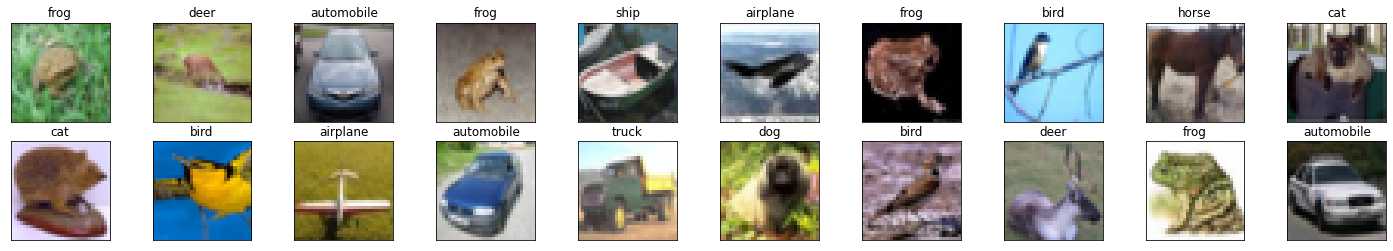

In [7]:
images,labels=next(iter(train_loader))
images=images.numpy()
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

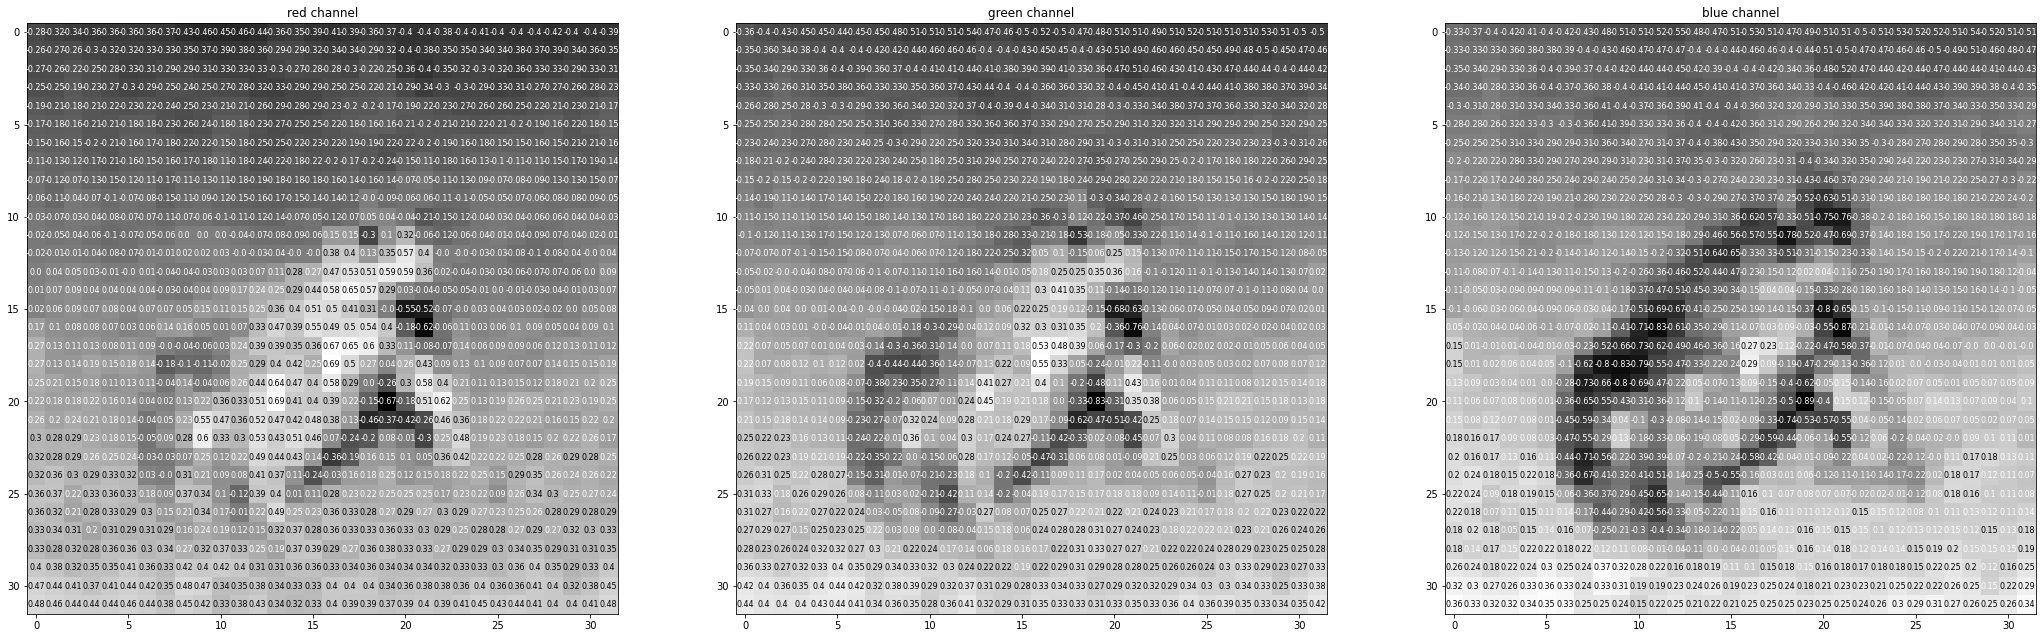

In [8]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')



In [16]:
#Define CNN Model
from torch import nn
import torch.nn.functional as F

class CifarNet(nn.Module):
  def __init__(self):
    super(CifarNet,self).__init__()
    #convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3,16,5,padding=1)
    #sees 16x16x16 image tensor because size is reduced due to 2x2 pool
    self.conv2 = nn.Conv2d(16,32,5,padding=1)
    #sees 8x8x32 image tensor because size is reduced due to 2x2 pool
    #32 due to output channel
    self.pool = nn.MaxPool2d(2,2)
    #32*4*4 is the output size
    self.fc1 = nn.Linear(32*6*6,64)
    self.fc2 = nn.Linear(64,10)
    self.dropout=nn.Dropout(p=0.3)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,32*6*6)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    
    return x

model = CifarNet()
print(model)



CifarNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(),lr=0.02)

In [18]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.815371 	Validation Loss: 1.490439
Validation loss decreased (inf --> 1.490439).  Saving model ...
Epoch: 2 	Training Loss: 1.455117 	Validation Loss: 1.300016
Validation loss decreased (1.490439 --> 1.300016).  Saving model ...
Epoch: 3 	Training Loss: 1.293702 	Validation Loss: 1.259221
Validation loss decreased (1.300016 --> 1.259221).  Saving model ...
Epoch: 4 	Training Loss: 1.179164 	Validation Loss: 1.071519
Validation loss decreased (1.259221 --> 1.071519).  Saving model ...
Epoch: 5 	Training Loss: 1.095194 	Validation Loss: 1.052351
Validation loss decreased (1.071519 --> 1.052351).  Saving model ...
Epoch: 6 	Training Loss: 1.026779 	Validation Loss: 0.977204
Validation loss decreased (1.052351 --> 0.977204).  Saving model ...
Epoch: 7 	Training Loss: 0.969538 	Validation Loss: 0.948130
Validation loss decreased (0.977204 --> 0.948130).  Saving model ...
Epoch: 8 	Training Loss: 0.924802 	Validation Loss: 0.943238
Validation loss decreased (0.94813

In [19]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [20]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.903573

Test Accuracy of airplane: 71% (715/1000)
Test Accuracy of automobile: 76% (764/1000)
Test Accuracy of  bird: 58% (585/1000)
Test Accuracy of   cat: 48% (487/1000)
Test Accuracy of  deer: 61% (610/1000)
Test Accuracy of   dog: 63% (633/1000)
Test Accuracy of  frog: 68% (680/1000)
Test Accuracy of horse: 78% (787/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 83% (838/1000)

Test Accuracy (Overall): 69% (6909/10000)
